In [38]:
import csv
import re
import urllib
import pandas as pd
import numpy as np
import ast
import torch 
from collections import defaultdict
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
import matplotlib.colors
import seaborn as sns
from collections import Counter
from transformers import AutoConfig
from transformers import AutoTokenizer, AutoModel
import torch
from umap import UMAP
import plotly.express as px
import plotly.graph_objects as go


In [4]:
data = pd.read_csv('/Users/ruxandramihai/Desktop/embedded.csv', on_bad_lines='skip')

In [6]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruxandramihai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
if type(data['Abstract']) is list:
    text = data['Abstract']
else:
    text = data['Abstract'].tolist()

model = BERTopic(
    vectorizer_model=vectorizer_model,
    language='english', calculate_probabilities=True,
    verbose=True
)
topics, probs = model.fit_transform(text)

2024-07-29 11:31:47,491 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/82 [00:00<?, ?it/s]

2024-07-29 11:31:56,202 - BERTopic - Embedding - Completed ✓
2024-07-29 11:31:56,203 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-29 11:32:00,443 - BERTopic - Dimensionality - Completed ✓
2024-07-29 11:32:00,444 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-29 11:32:00,661 - BERTopic - Cluster - Completed ✓
2024-07-29 11:32:00,663 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-29 11:32:01,411 - BERTopic - Representation - Completed ✓


In [71]:
freq = model.get_topic_info()

In [73]:
model.visualize_term_rank(log_scale=True)

In [74]:
model.visualize_topics()

In [11]:
model.visualize_barchart(n_words=5, top_n_topics=20)

In [49]:
timestamps = data['Date'].to_list()

In [53]:
data['year'] = pd.to_datetime(data['Date'], format='%Y %b %d', errors='coerce').dt.year

In [55]:
data['year'].fillna(pd.to_datetime(data['Date'], format='%Y %b', errors='coerce').dt.year, inplace=True)
data['year'] = data['year'].astype(int)
data = data.loc[data['year'].notna(), :]
timestamps = data['year'].to_list()
topics_over_time = model.topics_over_time(text, timestamps)

In [89]:
model.visualize_topics_over_time(topics_over_time)

In [84]:
topics_over_time

,Topic,Words,Frequency,Timestamp,Name
0,-1,"wmh, phosphorylated synuclein, lewy, lewy bodi...",11,2017,-1_disease_csf_brain_ad
1,0,"ad, csfserum albumin, biomarkers, csfserum, al...",3,2017,0_ad_biomarkers_amyloid_csf
2,2,"ms, remyelination, multiple sclerosis, scleros...",4,2017,2_ms_multiple sclerosis_sclerosis_multip...
3,3,"autophagy, pd, degradation, mutations underlyi...",1,2017,3_autophagy_mtorc1_autophagosome_pathway
4,5,"outcome, cardiac, 72 hours, tau, cardiac arrest",1,2017,5_delirium_surgery_postoperative_injury
...,...,...,...,...,...
393,49,"hd, huntingtons disease, huntingtons, protein ...",2,2024,49_hd_huntingtons disease_huntingtons_di...
394,53,"ec, vascular, inflammatory activation, vascula...",1,2024,53_svd_vascular_dysfunction_endothelial
395,54,"connectivity, functional connectivity, dynamic...",1,2024,54_connectivity_functional_weight_mcs
396,56,"bd, patients bd, hc, bd hc, csfa42",1,2024,56_bd_bipolar_bipolar disorder_disorder


In [91]:
topics_over_time_filtered = topics_over_time[topics_over_time['Topic'] != -1]
topic_counts = topics_over_time_filtered.groupby(['Timestamp', 'Topic'])['Frequency'].sum().reset_index()
total_counts_per_year = topic_counts.groupby('Timestamp')['Frequency'].sum().reset_index(name='Total')
topic_counts = pd.merge(topic_counts, total_counts_per_year, on='Timestamp')
topic_counts['Percentage'] = (topic_counts['Frequency'] / topic_counts['Total']) * 100

topic_names = topics_over_time_filtered[['Topic', 'Name']].drop_duplicates().set_index('Topic')['Name'].to_dict()
fig = go.Figure()
unique_topics = sorted(topic_counts['Topic'].unique())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
topic_color_map = {topic: colors[i % len(colors)] for i, topic in enumerate(unique_topics)}

for topic in unique_topics:
    topic_data = topic_counts[topic_counts['Topic'] == topic]
    fig.add_trace(go.Scatter(
        x=topic_data['Timestamp'],
        y=topic_data['Percentage'],
        mode='lines+markers',
        name=topic_names.get(topic, f'Topic {topic}'),  
        line=dict(color=topic_color_map[topic]),
        marker=dict(color=topic_color_map[topic])
    ))
fig.update_layout(
    title='Topics Over Time',
    xaxis_title='Year',
    yaxis_title='Percentage of Total Publications',
    legend_title='Topics'
)
fig.show()


In [14]:
embeddings = data['ada_embedding'].apply(lambda x: np.array(eval(x)))
umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings.tolist())
df = pd.DataFrame(umap_model.embedding_, columns=["x", "y"])
df["topic"] = topics

In [16]:
data = pd.concat([data, df[['x', 'y', 'topic']]], axis=1)

In [18]:
# author embeddings 
author_embeddings_dict = defaultdict(list)

for index, row in data.iterrows():
    authors = row['Authors'].split(',')
    author_embeddings = row['ada_embedding']
    author_embeddings = np.array([float(e) for e in author_embeddings.strip('[]').split(',')])
    for author in authors:
        author_name = author.strip()
        author_embeddings_dict[author_name].append(author_embeddings)
# take the mean of the embeddings for each author
author_mean_embeddings = {author: np.mean(embeddings, axis=0) for author, embeddings in author_embeddings_dict.items()}

all_authors = list(author_mean_embeddings.keys())
all_mean_embeddings = np.array(list(author_mean_embeddings.values()))

In [31]:
# umap for authors
umap_model_authors = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine')
umap_embeddings_authors = umap_model_authors.fit_transform(all_mean_embeddings)

In [33]:
umap_authors_df = pd.DataFrame(umap_embeddings_authors, columns=["x", "y"])
umap_authors_df['author'] = all_authors

In [34]:
umap_authors_df

,x,y,author
0,4.873090,-1.265402,Parker TD(1)(2)(3)
1,3.913852,0.557808,Hardy C(2)
2,3.914252,0.556712,Keuss S(2)
3,3.913362,0.558461,Coath W(2)
4,3.914267,0.558586,Cash DM(2)(4)
...,...,...,...
35909,16.318031,8.369564,Taylor \nPC(2)
35910,16.319082,8.370698,Amor S(7)(8)
35911,16.318796,8.370436,Antel JP(4)
35912,16.318697,8.369995,Matthews PM(1)(9)


In [21]:
unique_authors = len(author_embeddings_dict)
author_embeddings_count = {author: len(embeddings) for author, embeddings in author_embeddings_dict.items()}

Search by author 

In [26]:
query = "Barnaghi"  

/var/folders/w1/09kv9yxx35l70vmkfzryr3d40000gn/T/ipykernel_43937/1822634410.py:26: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



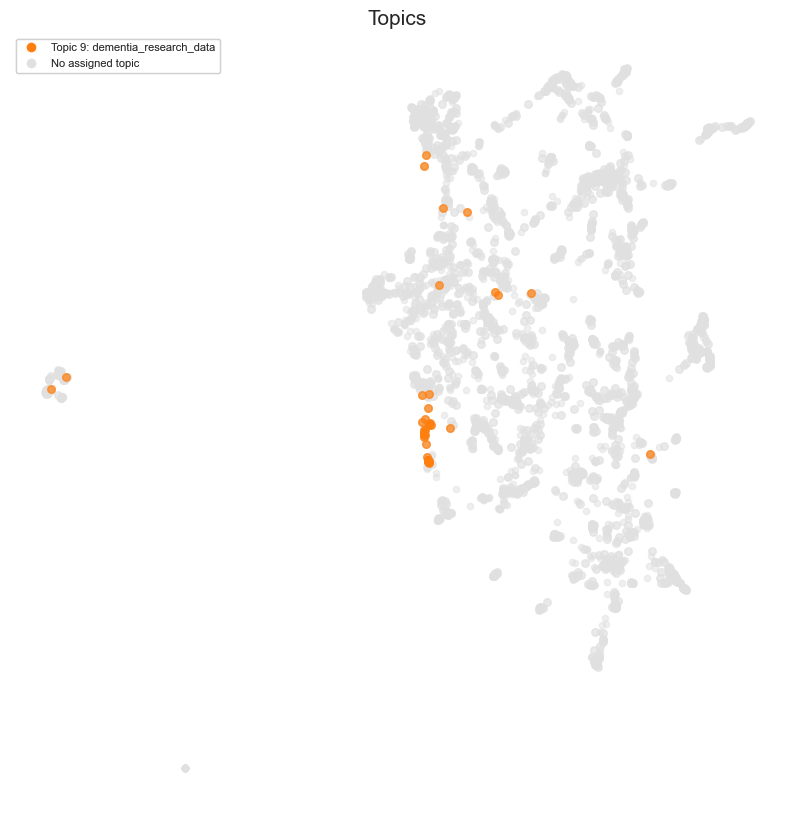

In [27]:
matching_authors = set()
for authors in data['Authors']:
    author_list = authors.split(',')
    for author in author_list:
        if query.lower() in author.lower():
            matching_authors.add(author.strip())

matching_topics = set()
for index, row in data.iterrows():
    authors = row['Authors'].split(',')
    if isinstance(row['topic'], str): 
        topics = row['topic'].split(',')
    else:
        topics = [row['topic']] 
    for author in authors:
        if author.strip() in matching_authors:
            matching_topics.update(topics)

top_n = 62
fontsize = 8  

to_plot = df.copy()
to_plot[df.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]
cmap = plt.cm.get_cmap('tab20', 62)  

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 10)) 

scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=20, alpha=.5, label='No topic assigned')  
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c='#E0E0E0', s=30, alpha=.7) 

legend_handles = []
legend_labels = []
centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
    topic = int(row[1].topic)
    if topic in matching_topics:
        description = "_".join([x[0] for x in model.get_topic(topic)[:3]])
        legend_handles.append(matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(topic), markersize=8))
        legend_labels.append(f"Topic {topic}: {description}")

legend_handles.append(matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor="#E0E0E0", markersize=8))
legend_labels.append("No assigned topic")

legend1 = ax.legend(legend_handles, legend_labels, loc="upper left", fontsize=fontsize)
ax.add_artist(legend1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(left=False, bottom=False)

for topic in matching_topics:
    matching_points = non_outliers[non_outliers['topic'] == topic]
    ax.scatter(matching_points['x'], matching_points['y'], c=cmap(topic), s=30, alpha=.7)

plt.title('Topics', fontsize=15)
plt.xticks([], [])
plt.yticks([], [])
plt.show()